In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

from hydra import compose, initialize
import matplotlib.pyplot as plt
import os
from tqdm.auto import tqdm
import h5py
import pandas as pd
import numpy as np
from scipy.stats import pearsonr, spearmanr, wilcoxon
from UniversalUnconsciousness.data_utils import *
from UniversalUnconsciousness.plot_utils import *
from UniversalUnconsciousness.power_analysis import *

plt.style.use('UniversalUnconsciousness.sci_style')
load_font()

In [3]:
with initialize(version_base="1.3", config_path="../../UniversalUnconsciousness/DeLASE_analysis/conf"):
    cfg = compose(config_name="config")

In [4]:
cfg.params.low_pass = None
cfg.params.high_pass = None

cfg.params.stride = 15
cfg.params.window = 15

In [5]:
anesthetic_agent_list = cfg.plotting.anesthetic_agent_list
img_save_dir = cfg.plotting.img_save_dir
curve_colors = cfg.plotting.curve_colors
loc_roc_colors = cfg.plotting.loc_roc_colors
os.makedirs(img_save_dir, exist_ok=True)

In [6]:
agent_data = get_agent_data(cfg, use_individiual_areas=False, verbose=False)

  0%|          | 0/3 [00:00<?, ?it/s]

Only 1 valid windows could be found for section 'awake lever1' with times [-36.120676111111116, -26.045618333333337]


In [7]:
area = 'all'
# save_dir = "/orcd/data/ekmiller/001/eisenaj/UniversalUnconsciousness/power_analysis"
save_dir = "/scratch2/weka/millerlab/eisenaj/UniversalUnconsciousness/power_analysis"

# Freq correlations

In [8]:
top_percent = 0.1
doses = ['high']

power_info = {}
corr_power_info = {}
all_freq_powers = {}
for data_class, agent in tqdm(anesthetic_agent_list):
# for data_class, agent in tqdm([anesthetic_agent_list[1]]):
    delase_results = agent_data[(data_class, agent)]['delase_results']
    cfg.params.data_class = data_class
    agent_save_dir = os.path.join(save_dir, data_class, agent, area)
    power_info[(data_class, agent)] = {}
    corr_power_info[(data_class, agent)] = {}
    all_freq_powers[(data_class, agent)] = {}
    for monkey in agent_data[(data_class, agent)]['session_lists']:
        power_info[(data_class, agent)][monkey] = {}
        corr_power_info[(data_class, agent)][monkey] = {}
        all_freq_powers[(data_class, agent)][monkey] = {}
        # for dose in agent_data[(data_class, agent)]['session_lists'][monkey]:
        for dose in doses:
            power_info[(data_class, agent)][monkey][dose] = {}
            corr_power_info[(data_class, agent)][monkey][dose] = {}
            all_freq_powers[(data_class, agent)][monkey][dose] = {}
            for session in agent_data[(data_class, agent)]['session_lists'][monkey][dose]:
                if not os.path.exists(os.path.join(agent_save_dir, f'{session}__top_percent_{top_percent}_power_analysis.pkl')):
                    # raise ValueError(f"Session {session} does not exist")
                    print(f"Session {session} does not exist, skipping")
                else:
                    ret_dict = pd.read_pickle(os.path.join(agent_save_dir, f'{session}__top_percent_{top_percent}_power_analysis.pkl'))
                    freq_powers = ret_dict['freq_powers']
                    all_freq_powers[(data_class, agent)][monkey][dose][session] = freq_powers
                    corr_power_info[(data_class, agent)][monkey][dose][session] = {band: pearsonr(delase_results[session][area].stability_params.apply(lambda x: x[:int(top_percent*len(x))].mean()), freq_powers[band]).statistic for band in ['delta', 'theta', 'alpha', 'beta', 'gamma']}
                    # corr_power_info[(data_class, agent)][monkey][dose][session] = {band: spearmanr(delase_results[session][area].stability_params.apply(lambda x: x[:int(top_percent*len(x))].mean()), freq_powers[band]).statistic for band in ['delta', 'theta', 'alpha', 'beta', 'gamma']}
                    freq_r2_scores = ret_dict['freq_r2_scores']
                    power_info[(data_class, agent)][monkey][dose][session] = freq_r2_scores


  0%|          | 0/3 [00:00<?, ?it/s]

In [9]:
plot_info = {}
for data_class, agent in tqdm(anesthetic_agent_list):
    plot_info[(data_class, agent)] = {}
    for monkey in agent_data[(data_class, agent)]['session_lists']:
        plot_info[(data_class, agent)][monkey] = {}
        # for dose in agent_data[(data_class, agent)]['session_lists'][monkey]:
        for dose in doses:
            plot_info[(data_class, agent)][monkey][dose] = {band: [] for band in ['delta', 'theta', 'alpha', 'beta', 'gamma']}
            # for session in agent_data[(data_class, agent)]['session_lists'][monkey][dose]:
            for session in corr_power_info[(data_class, agent)][monkey][dose]:
                for band in ['delta', 'theta', 'alpha', 'beta', 'gamma']:
                    # plot_info[(data_class, agent)][monkey][dose][band].append(power_info[(data_class, agent)][monkey][dose][session][band])
                    plot_info[(data_class, agent)][monkey][dose][band].append(corr_power_info[(data_class, agent)][monkey][dose][session][band])

  0%|          | 0/3 [00:00<?, ?it/s]

propofol Mary high delta: p-val = 0.001953125
propofol Mary high theta: p-val = 0.001953125
propofol Mary high alpha: p-val = 0.001953125
propofol Mary high beta: p-val = 0.001953125
propofol Mary high gamma: p-val = 0.001953125
propofol MrJones high delta: p-val = 0.0009765625
propofol MrJones high theta: p-val = 0.0009765625
propofol MrJones high alpha: p-val = 0.0009765625
propofol MrJones high beta: p-val = 0.0009765625
propofol MrJones high gamma: p-val = 0.0029296875
ketamine SPOCK high delta: p-val = 0.0078125
ketamine SPOCK high theta: p-val = 0.0078125
ketamine SPOCK high alpha: p-val = 0.0078125
ketamine SPOCK high beta: p-val = 0.0078125
ketamine SPOCK high gamma: p-val = 0.0078125
ketamine PEDRI high delta: p-val = 0.0078125
ketamine PEDRI high theta: p-val = 0.0078125
ketamine PEDRI high alpha: p-val = 0.0234375
ketamine PEDRI high beta: p-val = 0.0390625
ketamine PEDRI high gamma: p-val = 0.0234375
dexmedetomidine SPOCK high delta: p-val = 0.0078125
dexmedetomidine SPOCK 

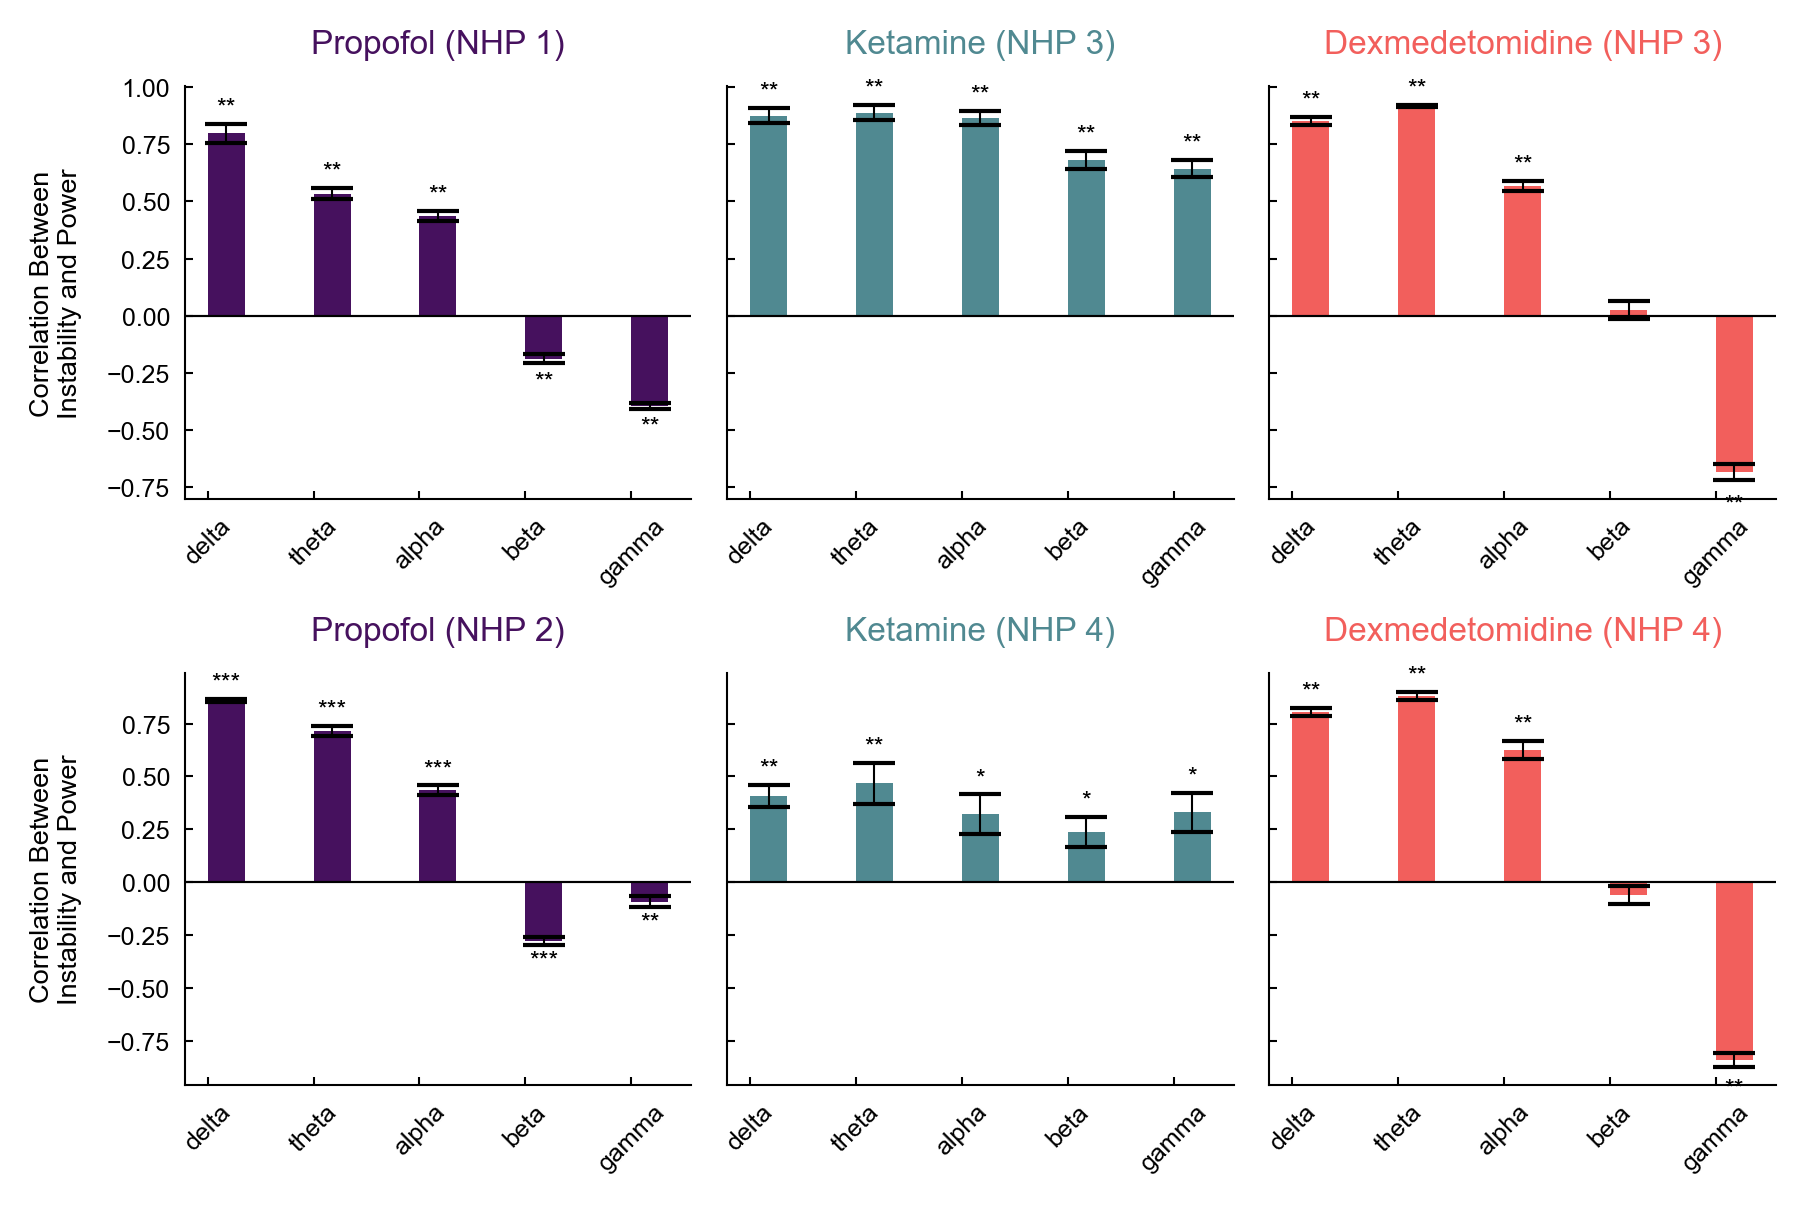

In [16]:

plot_power_analysis_grid(plot_info, anesthetic_agent_list, curve_colors, layout='nhp_rows', save_path=os.path.join(img_save_dir, 'power_analysis_grid.pdf'), figsize=(6, 4))

In [10]:
# Generate statistical table for power analysis
import numpy as np
from scipy import stats

# Map monkey names to NHP labels
monkey_to_nhp = {
    'Mary': 'NHP1',
    'MrJones': 'NHP2',
    'SPOCK': 'NHP3',
    'PEDRI': 'NHP4'
}

# Map agent names for display
agent_display_names = {
    'propofol': 'Propofol',
    'ketamine': 'Ketamine',
    'dexmedetomidine': 'Dexmedetomidine'
}

# Frequency band labels
band_labels = {
    'delta': 'Delta',
    'theta': 'Theta',
    'alpha': 'Alpha',
    'beta': 'Beta',
    'gamma': 'Gamma'
}

# Initialize list to store statistical results
statistical_results = []

# Iterate through plot_info structure
for (data_class, agent), agent_data_dict in plot_info.items():
    agent_display = agent_display_names.get(agent, agent.capitalize())
    
    for monkey, monkey_data_dict in agent_data_dict.items():
        nhp = monkey_to_nhp.get(monkey, monkey)
        
        for dose, dose_data_dict in monkey_data_dict.items():
            for band, data_list in dose_data_dict.items():
                # Convert to numpy array and remove NaN values
                arr = np.asarray(data_list)
                arr = arr[~np.isnan(arr)] if arr.size else arr
                
                if arr.size > 0:
                    # Compute statistics: Wilcoxon test against 0
                    # Using compute_wilcoxon_and_median_diff with zeros as first argument
                    try:
                        median_diff, p_val, ci = compute_wilcoxon_and_median_diff(
                            np.zeros(arr.size), 
                            arr, 
                            alternative='two-sided'
                        )
                        
                        # Store results
                        statistical_results.append({
                            'agent': agent_display,
                            'nhp': nhp,
                            'dose': dose.capitalize(),
                            'band': band_labels.get(band, band.capitalize()),
                            'p_value': p_val,
                            'median_correlation': median_diff,
                            'ci_lower': ci[0],
                            'ci_upper': ci[1]
                        })
                    except Exception as e:
                        # If computation fails, store NaN values
                        statistical_results.append({
                            'agent': agent_display,
                            'nhp': nhp,
                            'dose': dose.capitalize(),
                            'band': band_labels.get(band, band.capitalize()),
                            'p_value': np.nan,
                            'median_correlation': np.nan,
                            'ci_lower': np.nan,
                            'ci_upper': np.nan
                        })
                else:
                    # No valid data
                    statistical_results.append({
                        'agent': agent_display,
                        'nhp': nhp,
                        'dose': dose.capitalize(),
                        'band': band_labels.get(band, band.capitalize()),
                        'p_value': np.nan,
                        'median_correlation': np.nan,
                        'ci_lower': np.nan,
                        'ci_upper': np.nan
                    })

# Create HTML table from statistical results
def create_html_table(results, band_labels_dict):
    """Create an HTML table from statistical results that can be copied into Word."""
    html = ['<table border="1" cellpadding="5" cellspacing="0" style="border-collapse: collapse;">']
    
    # Header row
    html.append('<tr>')
    html.append('<th>Agent</th>')
    html.append('<th>NHP</th>')
    html.append('<th>Dose</th>')
    html.append('<th>Band</th>')
    html.append('<th>p-value</th>')
    html.append('<th>Median Correlation</th>')
    html.append('<th>95% CI</th>')
    html.append('</tr>')
    
    # Data rows
    for result in results:
        html.append('<tr>')
        html.append(f'<td>{result["agent"]}</td>')
        html.append(f'<td>{result["nhp"]}</td>')
        html.append(f'<td>{result["dose"]}</td>')
        html.append(f'<td>{result["band"]}</td>')
        
        # Format p-value
        if np.isfinite(result["p_value"]):
            p_str = f'{result["p_value"]:.6f}'
        else:
            p_str = 'N/A'
        html.append(f'<td>{p_str}</td>')
        
        # Format median correlation
        if np.isfinite(result["median_correlation"]):
            median_str = f'{result["median_correlation"]:.4f}'
        else:
            median_str = 'N/A'
        html.append(f'<td>{median_str}</td>')
        
        # Format CI
        if np.isfinite(result["ci_lower"]) and np.isfinite(result["ci_upper"]):
            ci_str = f'[{result["ci_lower"]:.4f}, {result["ci_upper"]:.4f}]'
        else:
            ci_str = 'N/A'
        html.append(f'<td>{ci_str}</td>')
        html.append('</tr>')
    
    html.append('</table>')
    return '\n'.join(html)

# Sort results by agent first (custom order: Propofol -> Ketamine -> Dexmedetomidine), 
# then by NHP, then by dose, then by band
agent_order = {'Propofol': 0, 'Ketamine': 1, 'Dexmedetomidine': 2}
nhp_order = {'NHP1': 0, 'NHP2': 1, 'NHP3': 2, 'NHP4': 3}
band_order = {'Delta': 0, 'Theta': 1, 'Alpha': 2, 'Beta': 3, 'Gamma': 4}
dose_order = {'High': 0, 'Low': 1}

statistical_results_sorted = sorted(
    statistical_results, 
    key=lambda x: (
        agent_order.get(x['agent'], 999),
        nhp_order.get(x['nhp'], 999),
        dose_order.get(x['dose'], 999),
        band_order.get(x['band'], 999)
    )
)

# Generate HTML table
html_table = create_html_table(statistical_results_sorted, band_labels)

# Save HTML table to the same directory as the notebook
html_file_path = os.path.join(cfg.plotting.img_save_dir, 'supp', 'statistical_results_table_power.html')
os.makedirs(os.path.dirname(html_file_path), exist_ok=True)
with open(html_file_path, 'w') as f:
    f.write(html_table)

print(f"Statistical results table saved to: {html_file_path}")
print(f"Total entries: {len(statistical_results_sorted)}")


Statistical results table saved to: /scratch2/weka/millerlab/eisenaj/UniversalUnconsciousness/figure_images/supp/statistical_results_table_power.html
Total entries: 30


# Freq Power Means and Comparisons

In [11]:
top_percent = 0.1
doses = ['high']

mean_power_info = {}
for data_class, agent in tqdm(anesthetic_agent_list):
# for data_class, agent in tqdm([anesthetic_agent_list[1]]):
    delase_results = agent_data[(data_class, agent)]['delase_results']
    cfg.params.data_class = data_class
    agent_save_dir = os.path.join(save_dir, data_class, agent, area)
    mean_power_info[(data_class, agent)] = {}
    for monkey in agent_data[(data_class, agent)]['session_lists']:
        mean_power_info[(data_class, agent)][monkey] = {}
        # for dose in agent_data[(data_class, agent)]['session_lists'][monkey]:
        for dose in doses:
            mean_power_info[(data_class, agent)][monkey][dose] = {}
            for session in agent_data[(data_class, agent)]['session_lists'][monkey][dose]:
                if not os.path.exists(os.path.join(agent_save_dir, f'{session}__top_percent_{top_percent}_power_analysis.pkl')):
                    # raise ValueError(f"Session {session} does not exist")
                    print(f"Session {session} does not exist, skipping")
                else:
                    ret_dict = pd.read_pickle(os.path.join(agent_save_dir, f'{session}__top_percent_{top_percent}_power_analysis.pkl'))
                    freq_powers = ret_dict['freq_powers']

                    section_info, section_info_extended, section_colors, infusion_start = get_section_info(session, cfg.params.all_data_dir, cfg.params.data_class, section_info_type='plot')
                    window_times = delase_results[session][area].window_start # s
                    window_times_min =(window_times - infusion_start) / 60
                    awake_bool = (window_times_min > section_info[0][1][0]) & (window_times_min < section_info[0][1][1])
                    anesthesia_bool = (window_times_min > section_info[2][1][0]) & (window_times_min < section_info[2][1][1])
                    emergence_bool = (window_times_min > section_info[4][1][0]) & (window_times_min < section_info[4][1][1])

                    mean_power_info[(data_class, agent)][monkey][dose][session] = {}
                    for band in ret_dict['freq_powers']:
                        awake_mean, anesthesia_mean, emergence_mean = ret_dict['freq_powers'][band][awake_bool].mean(), ret_dict['freq_powers'][band][anesthesia_bool].mean(), ret_dict['freq_powers'][band][emergence_bool].mean()

                        mean_power_info[(data_class, agent)][monkey][dose][session][band] = {
                            'awake_mean': awake_mean,
                            'anesthesia_mean': anesthesia_mean,
                            'emergence_mean': emergence_mean
                        }

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

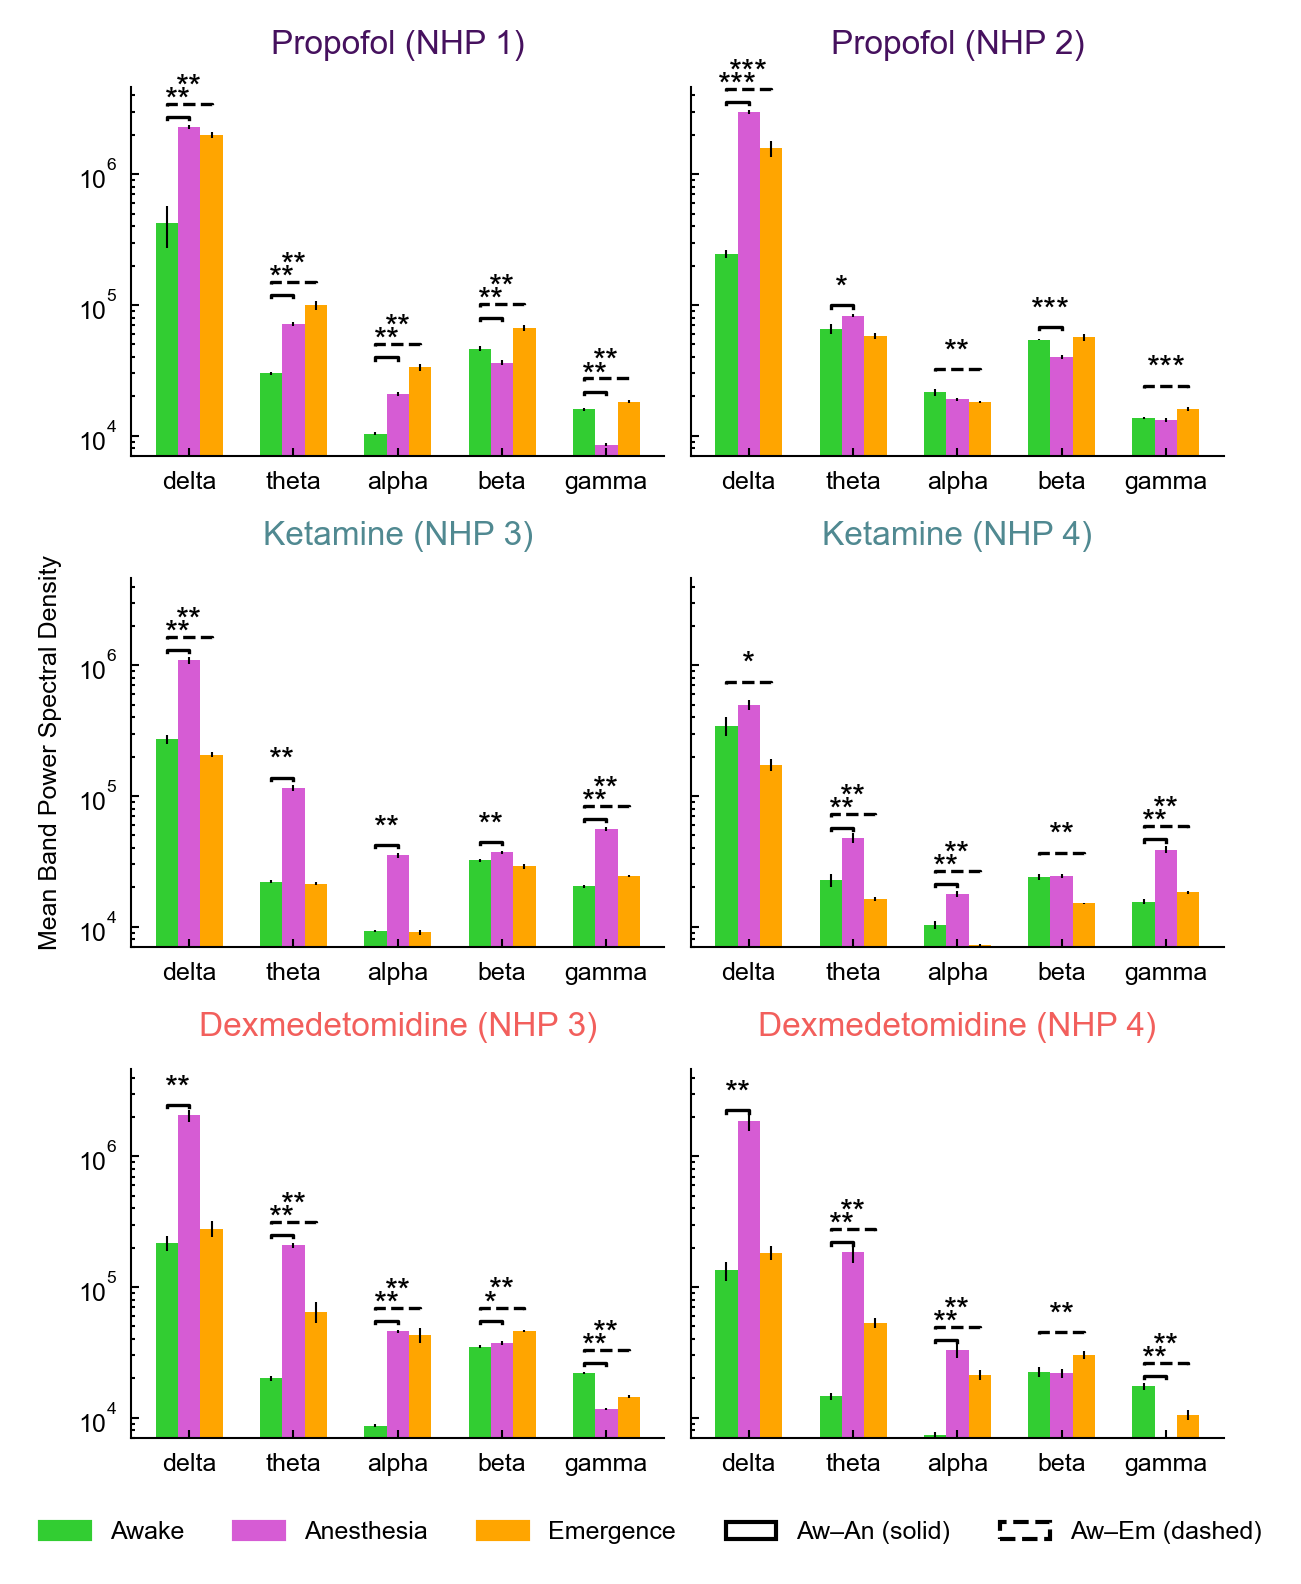

In [19]:
# Collect all band_means data for all agents first
all_band_means = {}
for data_class, agent in tqdm(anesthetic_agent_list):
    band_means = {}
    monkeys = list(mean_power_info[(data_class, agent)].keys())
    for monkey in monkeys:
        band_means[monkey] = {}
        for dose in ['high']:
            band_means[monkey][dose] = {}
            session_0 = list(mean_power_info[(data_class, agent)][monkey][dose].keys())[0]
            bands = list(mean_power_info[(data_class, agent)][monkey][dose][session_0].keys())
            for band in bands:
                band_means[monkey][dose][band] = {
                    'awake': [],
                    'anesthesia': [],
                    'emergence': []
                }
            
            for session in mean_power_info[(data_class, agent)][monkey][dose]:
                for band in bands:
                    band_means[monkey][dose][band]['awake'].append(mean_power_info[(data_class, agent)][monkey][dose][session][band]['awake_mean'])
                    band_means[monkey][dose][band]['anesthesia'].append(mean_power_info[(data_class, agent)][monkey][dose][session][band]['anesthesia_mean'])
                    band_means[monkey][dose][band]['emergence'].append(mean_power_info[(data_class, agent)][monkey][dose][session][band]['emergence_mean'])
    
    all_band_means[(data_class, agent)] = band_means

import matplotlib.patches as mpatches

# Get section colors from a sample session (assuming they're the same across sessions)
sample_data_class, sample_agent = anesthetic_agent_list[0]
sample_monkey = list(all_band_means[(sample_data_class, sample_agent)].keys())[0]
sample_session = list(mean_power_info[(sample_data_class, sample_agent)][sample_monkey]['high'].keys())[0]
cfg.params.data_class = sample_data_class
_, _, section_colors, _ = get_section_info(sample_session, cfg.params.all_data_dir, cfg.params.data_class, section_info_type='plot')

# Extract bands from the first agent (assuming all agents have the same bands)
bands = list(all_band_means[(sample_data_class, sample_agent)][sample_monkey]['high'].keys())

# ------------------------------------------------------------------
# BASIC SETTINGS
# ------------------------------------------------------------------
x_centers   = np.arange(len(bands)) * 2.8        # spacing between band clusters
bar_width   = 0.6                                # width of a single bar
alpha_thr   = 0.05                               # significance threshold

# colours – assume section_colors dict already exists
awake_color, anesthesia_color, emergence_color = (
    section_colors['Awake'],
    section_colors['Anesthesia'],
    section_colors['Emergence'],
)

# ------------------------------------------------------------------
# HELPER FUNCTIONS
# ------------------------------------------------------------------
def p_to_stars(p):
    """Convert p-value to significance stars; returns '' when p ≥ alpha_thr."""
    if p < 0.001:
        return '***'
    elif p < 0.01:
        return '**'
    elif p < alpha_thr:
        return '*'
    return ''


def draw_bracket(ax, x1, x2, y, label, ls):
    """Draw a square bracket with optional label."""
    if not label:               # skip drawing entirely if label is empty
        return
    h = y * 0.04                # tick height (4 % of y)
    ax.plot([x1, x1, x2, x2],
            [y,  y + h,  y + h, y],
            color='black', lw=0.8, linestyle=ls)
    ax.text((x1 + x2) / 2, y + h,
            label, ha='center', va='bottom', fontsize=8)


# ------------------------------------------------------------------
# SUB-PLOT FUNCTION
# ------------------------------------------------------------------
def build_subplot(ax, band_means, monkey, title):
    for i, band in enumerate(bands):
        # ----------------------------------------------------------
        # data
        # ----------------------------------------------------------
        awake       = np.array(band_means[monkey]['high'][band]['awake'])
        unconscious = np.array(band_means[monkey]['high'][band]['anesthesia'])
        emergence   = np.array(band_means[monkey]['high'][band]['emergence'])

        means = [awake.mean(), unconscious.mean(), emergence.mean()]
        sems  = [awake.std(ddof=1) / np.sqrt(len(awake)),
                unconscious.std(ddof=1) / np.sqrt(len(unconscious)),
                emergence.std(ddof=1) / np.sqrt(len(emergence))]

        # ----------------------------------------------------------
        # bars
        # ----------------------------------------------------------
        xc                     = x_centers[i]
        x_awake, x_unc, x_eme  = xc - bar_width, xc, xc + bar_width

        ax.bar(x_awake, means[0], bar_width, color=awake_color,      yerr=sems[0],
            label='Awake'       if i == 0 else '')
        ax.bar(x_unc,  means[1], bar_width, color=anesthesia_color, yerr=sems[1],
            label='Anesthesia' if i == 0 else '')
        ax.bar(x_eme,  means[2], bar_width, color=emergence_color,  yerr=sems[2],
            label='Emergence'  if i == 0 else '')

        # ----------------------------------------------------------
        # statistics & (conditional) brackets
        # ----------------------------------------------------------
        p_aw_unc = wilcoxon(awake, unconscious).pvalue
        p_aw_eme = wilcoxon(awake, emergence).pvalue

        label_aw_unc = p_to_stars(p_aw_unc)   # solid (lower) bracket
        label_aw_eme = p_to_stars(p_aw_eme)   # dashed (upper) bracket

        ymax  = max(means)
        y_low = ymax * 1.15                   # Awake–Anesthesia
        y_hi  = ymax * 1.45                   # Awake–Emergence

        draw_bracket(ax, x_awake, x_unc, y_low, label_aw_unc, ls='-')
        draw_bracket(ax, x_awake, x_eme, y_hi,  label_aw_eme, ls='--')

    # --------------------------------------------------------------
    # cosmetics
    # --------------------------------------------------------------
    ax.set_title(title, color=cfg.plotting.curve_colors[title.split(' ')[0].lower()])
    ax.set_xticks(x_centers)
    ax.set_xticklabels(bands)
    # if monkey == 'SPOCK' or monkey == 'Mary':
    #     ax.set_ylabel('Mean Band Power Spectral Density')
    ax.set_yscale('log')
    ax.set_ylim(bottom=7000)                   # maintain previous lower bound


# ------------------------------------------------------------------
# BUILD FIGURE - Single figure with 3 rows × 2 columns
# ------------------------------------------------------------------
fig, axes = plt.subplots(3, 2, figsize=(4,5), sharey=True)

# Define agent order and NHP mapping
agent_order = ['propofol', 'ketamine', 'dexmedetomidine']
monkey_to_nhp = {
    'Mary': 'NHP 1',
    'MrJones': 'NHP 2',
    'SPOCK': 'NHP 3',
    'PEDRI': 'NHP 4'
}

# Plot each agent in order
for row_idx, agent_name in enumerate(agent_order):
    # Find the corresponding (data_class, agent) tuple
    data_class_agent = None
    for dc, ag in anesthetic_agent_list:
        if ag == agent_name:
            data_class_agent = (dc, ag)
            break
    
    if data_class_agent is None:
        continue
    
    band_means = all_band_means[data_class_agent]
    monkeys = list(band_means.keys())
    
    # Plot the two NHPs for this agent
    for col_idx, monkey in enumerate(monkeys):
        ax = axes[row_idx, col_idx]
        nhp_name = monkey_to_nhp.get(monkey, monkey)
        title = f'{agent_name.capitalize()} ({nhp_name})'
        build_subplot(ax, band_means, monkey, title)

# unified legend at the bottom
handles = [
    mpatches.Patch(color=awake_color,       label='Awake'),
    mpatches.Patch(color=anesthesia_color,  label='Anesthesia'),
    mpatches.Patch(color=emergence_color,   label='Emergence'),
    mpatches.Patch(facecolor='white', edgecolor='black', linestyle='-',  label='Aw–An (solid)'),
    mpatches.Patch(facecolor='white', edgecolor='black', linestyle='--', label='Aw–Em (dashed)')
]
fig.legend(handles=handles, loc='center', bbox_to_anchor=(0.5, -0.02), ncol=5)

plt.tight_layout()
fig.text(-0.01, 0.5, 'Mean Band Power Spectral Density', va='center', rotation='vertical')
plt.savefig(os.path.join(cfg.plotting.img_save_dir, 'supp', 'power-analysis_with_anesth.pdf'),
            bbox_inches='tight', transparent=True)

plt.show()

In [20]:
area = 'all'
total_its = 0
for data_class, agent in tqdm(anesthetic_agent_list):
    for monkey in agent_data[(data_class, agent)]['session_lists']:
        for session in agent_data[(data_class, agent)]['session_lists'][monkey]['high']:
            total_its += 1
print(f"Total sessions: {total_its}")
iterator = tqdm(total=total_its)

power_spectra = {}
for data_class, agent in anesthetic_agent_list:
    agent_save_dir = os.path.join(save_dir, data_class, agent, area)
    power_spectra[(data_class, agent)] = {}
    for monkey in agent_data[(data_class, agent)]['session_lists']:
        power_spectra[(data_class, agent)][monkey] = {}
        for session in  agent_data[(data_class, agent)]['session_lists'][monkey]['high']:
            file_path = os.path.join(agent_save_dir, f'{session}__fft_analysis.pkl')
            if not os.path.exists(file_path):
                print(f"FFT analysis for {session} does not exist")
                raise ValueError("Stop here")
            else:
                ffts = pd.read_pickle(file_path)
                power_spectra[(data_class, agent)][monkey][session] = ffts
            iterator.update(1)
iterator.close()

  0%|          | 0/3 [00:00<?, ?it/s]

Total sessions: 53


  0%|          | 0/53 [00:00<?, ?it/s]

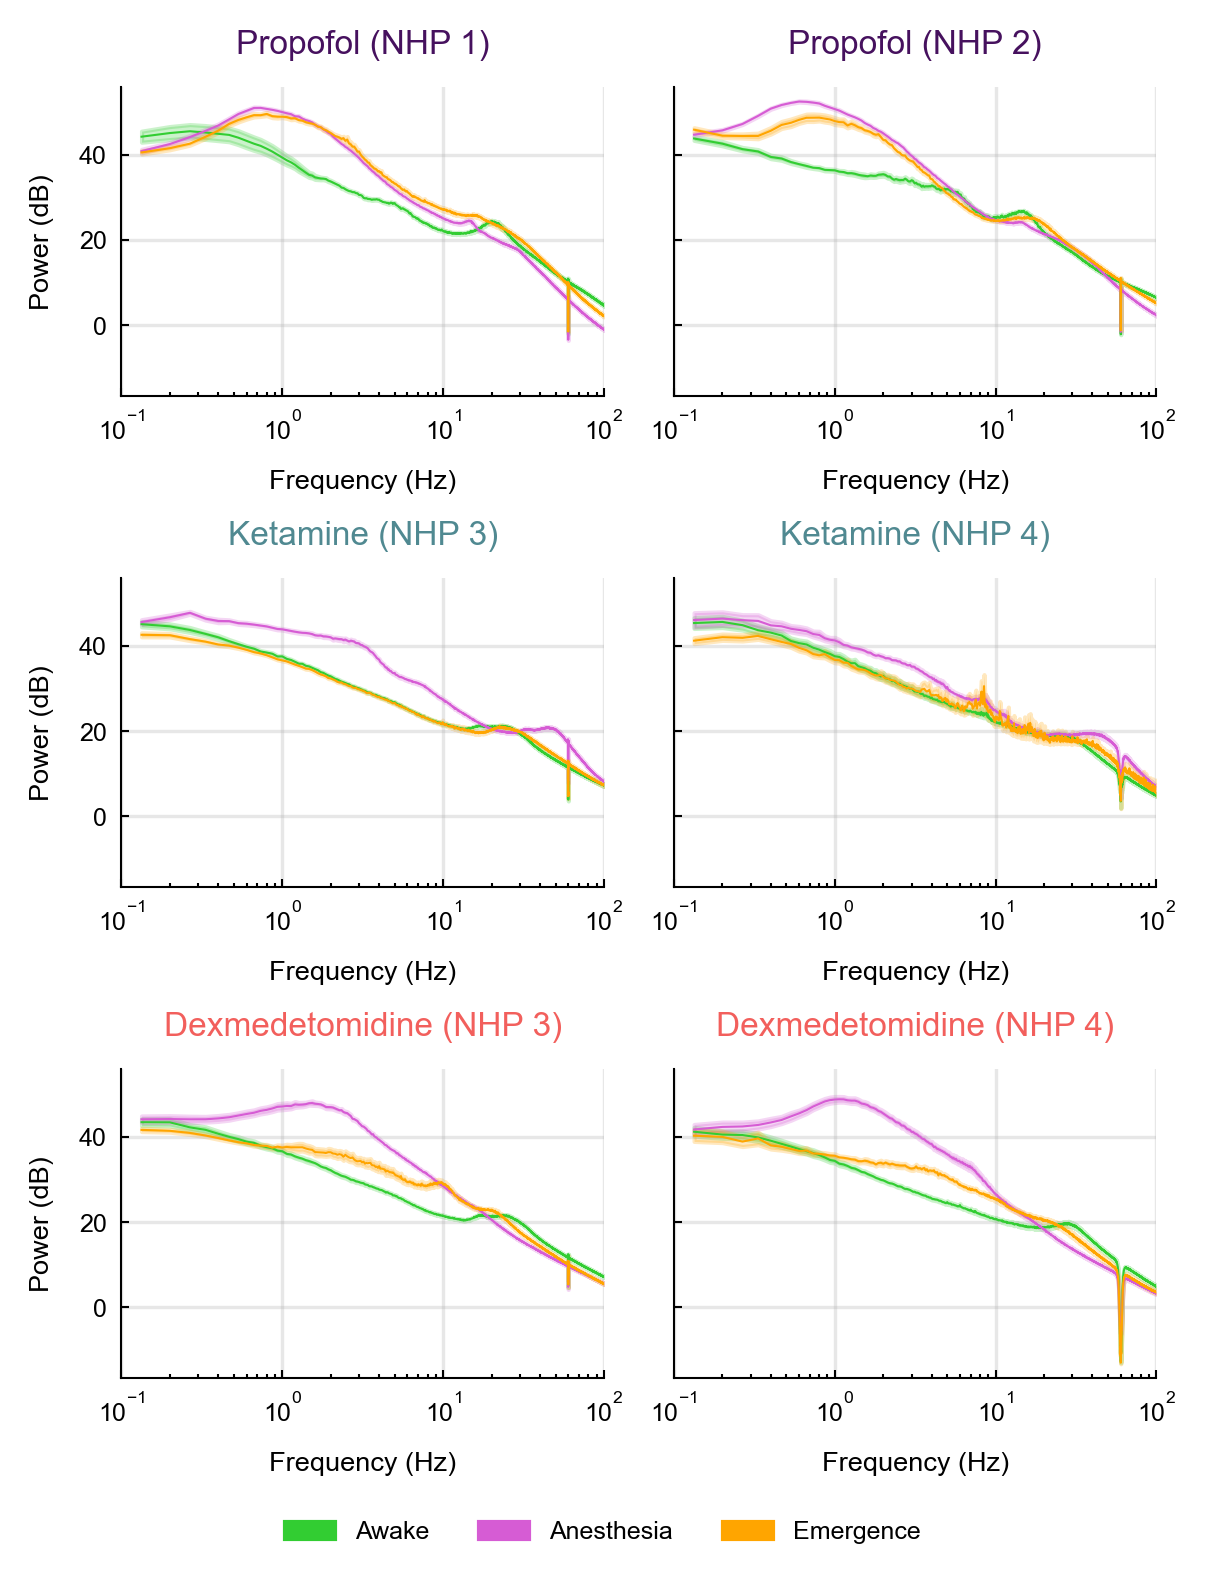

In [23]:
# ------------------------------------------------------------------
#  Power–spectrum plots (dB) – Single figure with 3 rows × 2 columns
# ------------------------------------------------------------------
import matplotlib.patches as mpatches

min_freq, max_freq = 0.1, 100     # frequency window to display

# Get section colors from a sample session (assuming they're the same across sessions)
sample_data_class, sample_agent = anesthetic_agent_list[0]
sample_monkey = list(power_spectra[(sample_data_class, sample_agent)].keys())[0]
sample_sess = list(power_spectra[(sample_data_class, sample_agent)][sample_monkey].keys())[0]
cfg.params.data_class = sample_data_class
_, _, section_colors, _ = get_section_info(
    sample_sess, cfg.params.all_data_dir,
    cfg.params.data_class, section_info_type='plot'
)

# colours
awake_color, anesthesia_color, emergence_color = (
    section_colors['Awake'],
    section_colors['Anesthesia'],
    section_colors['Emergence'],
)

# ------------------------------------------------------------------
#  helper function
# ------------------------------------------------------------------
def build_subplot(ax, data_class, agent, monkey, title, agent_color):
    """Mean spectrum ± SEM (shaded) in dB."""
    # grab all sessions for this monkey
    sessions = power_spectra[(data_class, agent)][monkey]
    freqs    = sessions[next(iter(sessions))]['freqs']

    # stack spectra    (num_sessions  ×  num_freqs)
    awake_mat       = np.vstack([v['awake_power_spectrum']       for v in sessions.values()])
    anesthesia_mat  = np.vstack([v['anesthesia_power_spectrum']  for v in sessions.values()])
    emergence_mat   = np.vstack([v['emergence_power_spectrum']   for v in sessions.values()])

    # convert to dB
    def lin2db(x): return 10 * np.log10(x)

    awake_mean_lin      = awake_mat.mean(axis=0)
    anesthesia_mean_lin = anesthesia_mat.mean(axis=0)
    emergence_mean_lin  = emergence_mat.mean(axis=0)

    awake_sem_lin       = awake_mat.std(axis=0, ddof=1) / np.sqrt(awake_mat.shape[0])
    anesthesia_sem_lin  = anesthesia_mat.std(axis=0, ddof=1) / np.sqrt(anesthesia_mat.shape[0])
    emergence_sem_lin   = emergence_mat.std(axis=0, ddof=1) / np.sqrt(emergence_mat.shape[0])

    awake_db       = lin2db(awake_mean_lin)
    anesthesia_db  = lin2db(anesthesia_mean_lin)
    emergence_db   = lin2db(emergence_mean_lin)

    # SEM in dB (approx):  ΔdB = dB(mean+SEM) − dB(mean)
    awake_db_sem       = lin2db(awake_mean_lin + awake_sem_lin)       - awake_db
    anesthesia_db_sem  = lin2db(anesthesia_mean_lin + anesthesia_sem_lin) - anesthesia_db
    emergence_db_sem   = lin2db(emergence_mean_lin + emergence_sem_lin)  - emergence_db

    mask = (freqs >= min_freq) & (freqs <= max_freq)
    f    = freqs[mask]

    # plotting
    ax.plot(f, awake_db[mask],       c=awake_color,      label='Awake')
    ax.fill_between(f, awake_db[mask] - awake_db_sem[mask],
                       awake_db[mask] + awake_db_sem[mask],
                       color=awake_color, alpha=0.25)

    ax.plot(f, anesthesia_db[mask],  c=anesthesia_color, label='Anesthesia')
    ax.fill_between(f, anesthesia_db[mask] - anesthesia_db_sem[mask],
                       anesthesia_db[mask] + anesthesia_db_sem[mask],
                       color=anesthesia_color, alpha=0.25)

    ax.plot(f, emergence_db[mask],   c=emergence_color,  label='Emergence')
    ax.fill_between(f, emergence_db[mask] - emergence_db_sem[mask],
                       emergence_db[mask] + emergence_db_sem[mask],
                       color=emergence_color, alpha=0.25)

    # cosmetics
    ax.set_title(title, color=agent_color)
    ax.set_xscale('log')
    ax.set_xlim(min_freq, max_freq)
    ax.set_xlabel('Frequency (Hz)')
    if monkey in ['SPOCK', 'Mary']:     # left-hand subplot gets y-label
        ax.set_ylabel('Power (dB)')
    ax.grid(alpha=0.3)

# ------------------------------------------------------------------
#  figure layout - Single figure with 3 rows × 2 columns
# ------------------------------------------------------------------
fig, axes = plt.subplots(3, 2, figsize=(4, 5), sharey=True)

# Define agent order and NHP mapping
agent_order = ['propofol', 'ketamine', 'dexmedetomidine']
monkey_to_nhp = {
    'Mary': 'NHP 1',
    'MrJones': 'NHP 2',
    'SPOCK': 'NHP 3',
    'PEDRI': 'NHP 4'
}

# Plot each agent in order
for row_idx, agent_name in enumerate(agent_order):
    # Find the corresponding (data_class, agent) tuple
    data_class_agent = None
    for dc, ag in anesthetic_agent_list:
        if ag == agent_name:
            data_class_agent = (dc, ag)
            break
    
    if data_class_agent is None:
        continue
    
    data_class, agent = data_class_agent
    monkeys = list(power_spectra[data_class_agent].keys())
    agent_color = cfg.plotting.curve_colors[agent]
    
    # Plot the two NHPs for this agent
    for col_idx, monkey in enumerate(monkeys):
        ax = axes[row_idx, col_idx]
        nhp_name = monkey_to_nhp.get(monkey, monkey)
        title = f'{agent_name.capitalize()} ({nhp_name})'
        build_subplot(ax, data_class, agent, monkey, title, agent_color)

# unified legend at the bottom
handles = [
    mpatches.Patch(color=awake_color,      label='Awake'),
    mpatches.Patch(color=anesthesia_color, label='Anesthesia'),
    mpatches.Patch(color=emergence_color,  label='Emergence'),
]
fig.legend(handles=handles, loc='center', bbox_to_anchor=(0.5, -0.02), ncol=3)

plt.tight_layout()
plt.savefig(
    os.path.join(cfg.plotting.img_save_dir, 'supp',
                 'power-spectrum_dB.pdf'),
    bbox_inches='tight', transparent=True
)
plt.show()